In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
stores_df = pd.read_csv('stores.csv')
oil_df = pd.read_csv('oil.csv')
transactions_df = pd.read_csv('transactions.csv')

# Preview the data
print(train_df.head())
print(train_df.info())


   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


In [38]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())
print(stores_df.isnull().sum())
print(oil_df.isnull().sum())
print(transactions_df.isnull().sum())


id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
date           0
dcoilwtico    43
dtype: int64
date            0
store_nbr       0
transactions    0
dtype: int64


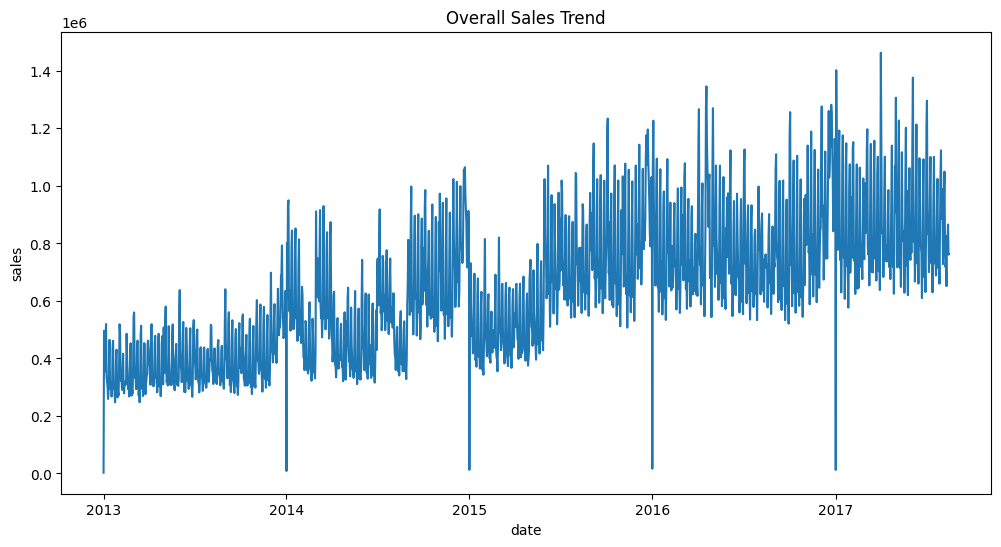

In [39]:
train_df['date'] = pd.to_datetime(train_df['date'])
sales_trend = train_df.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=sales_trend, x='date', y='sales')
plt.title('Overall Sales Trend')
plt.show()

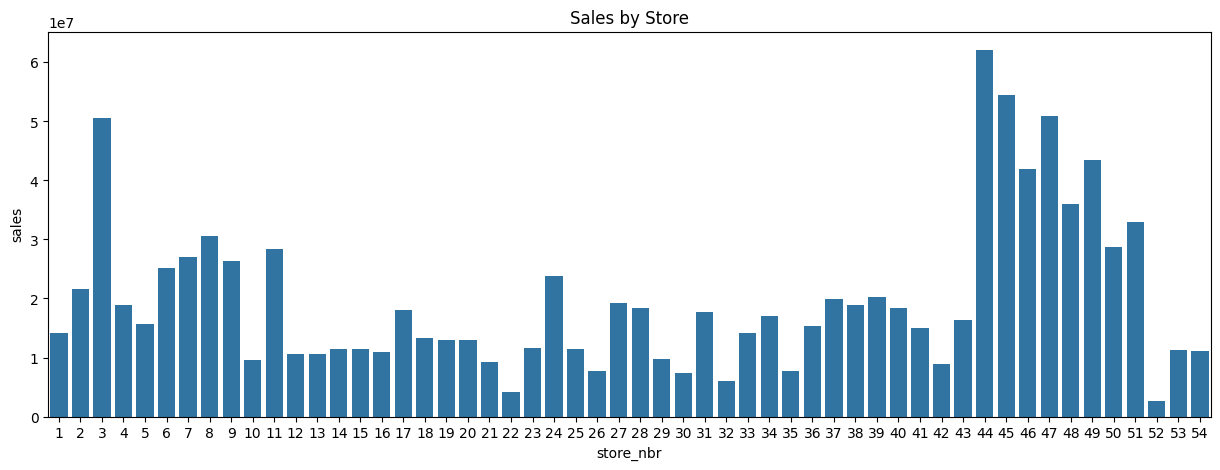

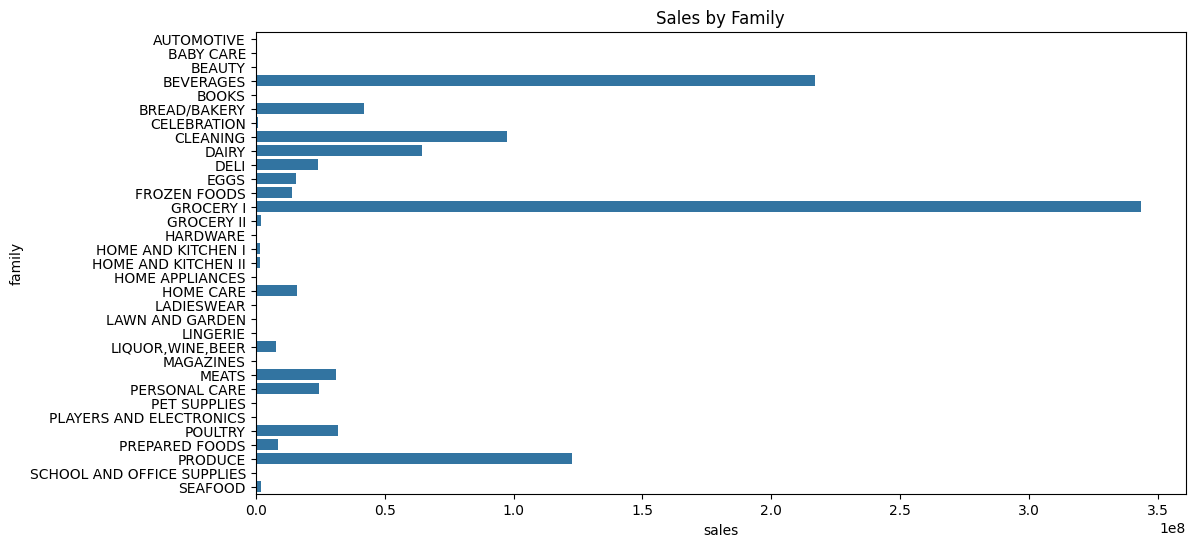

In [40]:
sales_by_store = train_df.groupby('store_nbr')['sales'].sum().reset_index()
sales_by_family = train_df.groupby('family')['sales'].sum().reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(data=sales_by_store, x='store_nbr', y='sales')
plt.title('Sales by Store')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=sales_by_family, x='sales', y='family')
plt.title('Sales by Family')
plt.show()


In [41]:
train_df['day'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year
train_df['day_of_week'] = train_df['date'].dt.dayofweek
train_df['is_weekend'] = (train_df['day_of_week'] >= 5).astype(int)

In [42]:
# Ensure 'date' columns are of the same type
transactions_df['date'] = pd.to_datetime(transactions_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])

train_df = train_df.merge(stores_df, on='store_nbr', how='left')
train_df = train_df.merge(transactions_df, on=['store_nbr', 'date'], how='left')
train_df = train_df.merge(oil_df, on='date', how='left')

# Fill missing values
train_df['transactions'] = train_df['transactions'].fillna(0)
train_df['dcoilwtico'] = train_df['dcoilwtico'].ffill()
train_df['dcoilwtico'] = train_df['dcoilwtico'].bfill()


In [43]:

from sklearn.preprocessing import StandardScaler, LabelEncoder

# Encode categorical variables
le = LabelEncoder()
train_df['family'] = le.fit_transform(train_df['family'])

# Define features and target
X = train_df[['store_nbr', 'family', 'day', 'month', 'year', 'day_of_week', 'is_weekend', 'transactions', 'dcoilwtico']]
y = train_df['sales']


In [44]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [45]:
from sklearn.decomposition import PCA

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Print explained variance ratio
print(f"Explained Variance Ratio (sum): {pca.explained_variance_ratio_.sum():.2f}")
print(f"Number of components: {pca.n_components_}")


Explained Variance Ratio (sum): 0.96
Number of components: 7


In [46]:
# from sklearn.model_selection import train_test_split

# # Split PCA-transformed data into train and validation sets
# X_train_pca, X_valid_pca, y_train, y_valid = train_test_split(X_pca, y, test_size=0.2, random_state=42)


In [47]:
print(X.isnull().sum())

store_nbr       0
family          0
day             0
month           0
year            0
day_of_week     0
is_weekend      0
transactions    0
dcoilwtico      0
dtype: int64


In [ ]:
# Import libraries
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor

# Define models
models = {
  "Linear Regression": LinearRegression(),
  "Ridge Regression": Ridge(alpha=1.0),
  "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
}


In [49]:
import numpy as np

def rmsle(y_true, y_pred):
    y_true = np.maximum(0, y_true) 
    y_pred = np.maximum(0, y_pred) 
    return np.mean((np.log1p(y_true) - np.log1p(y_pred))**2)


In [50]:
from sklearn.model_selection import RepeatedKFold

# Define repeated K-Fold cross-validation
n_splits = 5  # Number of splits
n_repeats = 3  # Number of repeats
rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)


In [ ]:
from sklearn.metrics import root_mean_squared_error, r2_score

results_pca_varied = {model_name: {"RMSE": [], "R2": [], "RMSLE": []} for model_name in models.keys()}

for train_idx, valid_idx in rkf.split(X_pca):
    X_train_pca, X_valid_pca = X_pca[train_idx], X_pca[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_pca, y_train)
        
        # Predict on validation data
        y_pred = model.predict(X_valid_pca)
        y_pred = np.maximum(0, y_pred)  # Ensure non-negative predictions
        
        # Calculate metrics
        rmse = root_mean_squared_error(y_valid, y_pred)
        r2 = r2_score(y_valid, y_pred)
        rmsle_score = rmsle(y_valid, y_pred)
        
        results_pca_varied[model_name]["RMSE"].append(rmse)
        results_pca_varied[model_name]["R2"].append(r2)
        results_pca_varied[model_name]["RMSLE"].append(rmsle_score)


In [ ]:
# Print average results for each model
for model_name, metrics in results_pca_varied.items():
    avg_rmse = np.mean(metrics["RMSE"])
    avg_r2 = np.mean(metrics["R2"])
    avg_rmsle = np.mean(metrics["RMSLE"])
    
    print(f"{model_name} Average Performance (Varied Splits):")
    print(f"  Avg RMSE: {avg_rmse:.2f}")
    print(f"  Avg R2 Score: {avg_r2:.2f}")
    print(f"  Avg RMSLE: {avg_rmsle:.4f}\n")


Linear Regression Average Performance (Varied Splits):
  Avg RMSE: 1059.83
  Avg R2 Score: 0.08
  Avg RMSLE: 12.5886

Ridge Regression Average Performance (Varied Splits):
  Avg RMSE: 1059.83
  Avg R2 Score: 0.08
  Avg RMSLE: 12.5886

Gradient Boosting Average Performance (Varied Splits):
  Avg RMSE: 564.37
  Avg R2 Score: 0.74
  Avg RMSLE: 6.1370



In [ ]:
# print individual 
for model_name, metrices in results_pca_varied.items():
    print(f"{model_name} Results:")
    print(f"  RMSE: {metrices['RMSE']}")
    print(f"  R2: {metrices['R2']}")
    print(f"  RMSLE: {metrices['RMSLE']}\n")

Linear Regression Results:
  RMSE: [np.float64(1071.9783827396145), np.float64(1048.3602722499286), np.float64(1060.1599492771875), np.float64(1058.8496803310477), np.float64(1059.823739095653), np.float64(1048.721291247608), np.float64(1061.8142915413532), np.float64(1051.0497340625159), np.float64(1072.3177575087507), np.float64(1065.2172108816467), np.float64(1059.9408787835791), np.float64(1061.5337222654055), np.float64(1068.5238040653958), np.float64(1051.327272263439), np.float64(1057.89649445565)]
  R2: [0.075372786997706, 0.07644832055158945, 0.0742293743632545, 0.07526441511443549, 0.07375566385454091, 0.07468775971296282, 0.07597510786816097, 0.07534185195632959, 0.07409670211076069, 0.07496002510825084, 0.07484286315882394, 0.07564847157524213, 0.0743712404260558, 0.07538322240318462, 0.07483511466678616]
  RMSLE: [np.float64(12.588477770835112), np.float64(12.588998436480662), np.float64(12.577602960230509), np.float64(12.609486420682812), np.float64(12.578556844206346), n

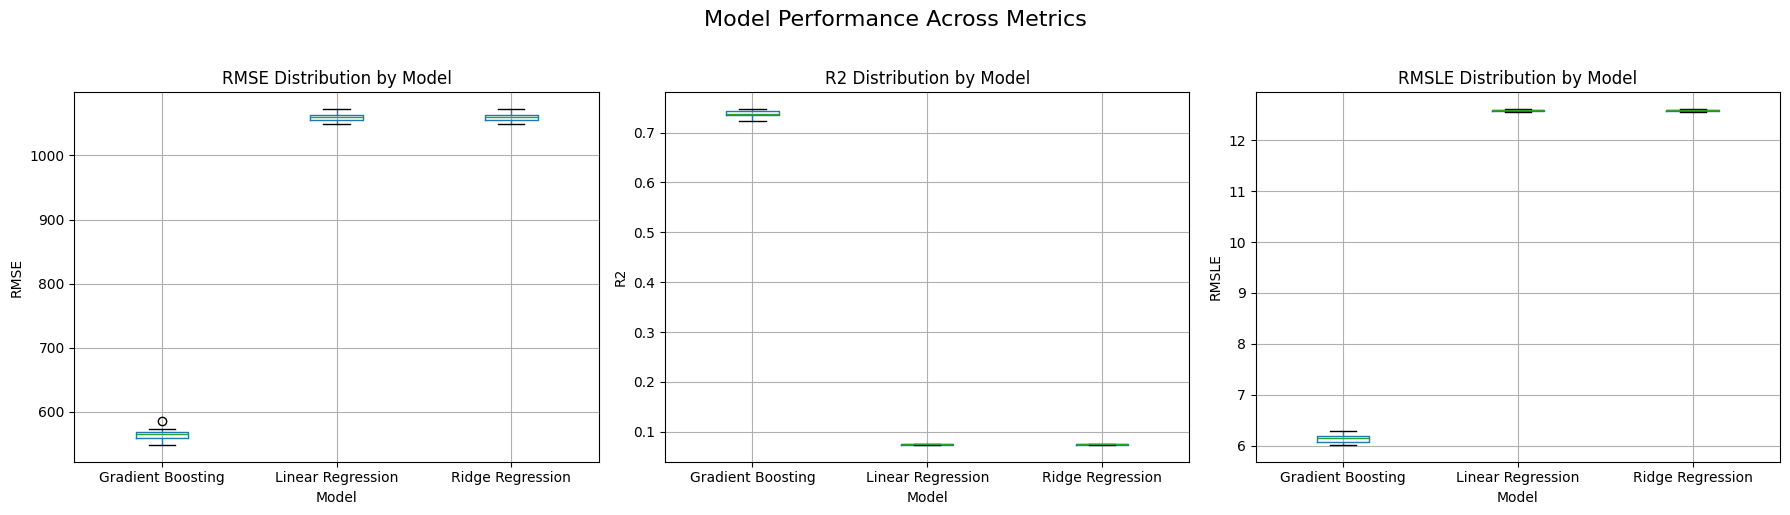

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

metrics_df = pd.DataFrame({
    "Model": [],
    "Metric": [],
    "Value": []
})

for model_name, metrics in results_pca_varied.items():
    for metric, values in metrics.items():
        for value in values:
            metrics_df = pd.concat([
                metrics_df,
                pd.DataFrame({"Model": [model_name], "Metric": [metric], "Value": [value]})
            ], ignore_index=True)

# Create separate plots for each metric
metrics = ["RMSE", "R2", "RMSLE"]
fig, axes = plt.subplots(1, len(metrics), figsize=(18, 5), sharey=False)

for i, metric in enumerate(metrics):
    ax = axes[i]
    metric_data = metrics_df[metrics_df["Metric"] == metric]
    metric_data.boxplot(column="Value", by="Model", ax=ax)
    ax.set_title(f"{metric} Distribution by Model")
    ax.set_ylabel(metric)
    ax.set_xlabel("Model")

plt.suptitle("Model Performance Across Metrics", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
iteration_results = pd.DataFrame()

for model_name, metrics in results_pca_varied.items():
    for metric, values in metrics.items():
        temp_df = pd.DataFrame({
            "Model": model_name,
            "Iteration": range(1, len(values) + 1),
            "Metric": metric,
            "Value": values
        })
        iteration_results = pd.concat([iteration_results, temp_df], ignore_index=True)


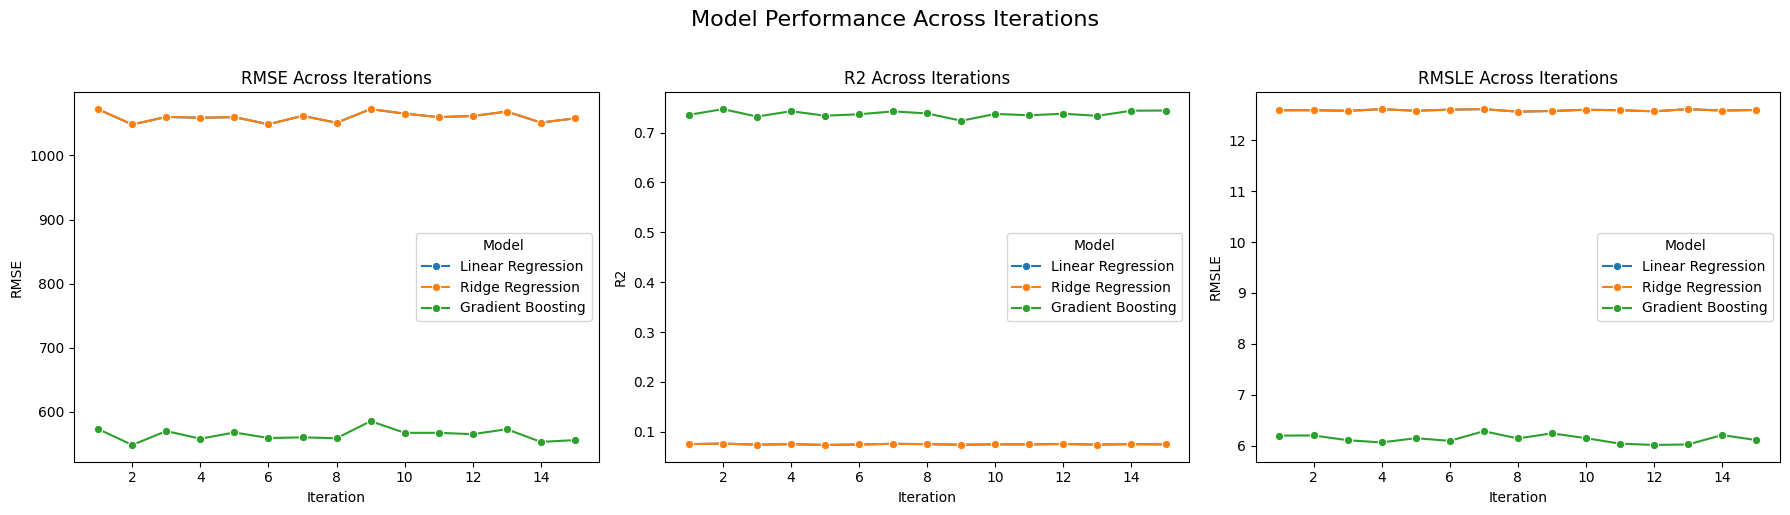

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Metrics to plot
metrics = ["RMSE", "R2", "RMSLE"]

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    metric_data = iteration_results[iteration_results["Metric"] == metric]
    
    sns.lineplot(
        data=metric_data,
        x="Iteration",
        y="Value",
        hue="Model",
        marker="o",
        ax=ax
    )
    ax.set_title(f"{metric} Across Iterations")
    ax.set_ylabel(metric)
    ax.set_xlabel("Iteration")
    ax.legend(title="Model", loc="best")

plt.suptitle("Model Performance Across Iterations", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()
